# Tutorial 3: Computing Unwindowed Power Spectra from BOSS DR12

In this tutorial we will use PolyBin3D to estimate the power spectra of a section of the BOSS DR12 dataset. We will compute both the standard window-convolved and new unwindowed spectra, and discuss various choices of weighting schemes. Much of the data-handling routines in this section are borrowed from the [Nbodykit cookbook](https://nbodykit.readthedocs.io/en/latest/cookbook/index.html). The PolyBin3D code is simple to use, but there's a lot of preliminaries to get through before we can use it. To avoid having to run this code on a cluster, we'll focus on the smallest BOSS data patch, and compute spectra at comparatively low $k$.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [28]:
%pylab inline
import os, sys
from nbodykit.lab import * # for various utility functions
import PolyBin3D as pb # the main code
from scipy.interpolate import UnivariateSpline, interp1d
import healpy as hp # for angular mask

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();
    
    plt.hlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.vlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.xlim(-0.5,2*pspec.Nk-0.5)
    plt.ylim(2*pspec.Nk-0.5,-0.5)
    plt.xlabel('Bin Index 1',fontsize=12)
    plt.ylabel('Bin Index 2',fontsize=12)

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/nbodykit-env/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Download the Data

First, we'll download some observational data. Here, we use the SGC LOWZ data (from the SDSS [website](https://data.sdss.org/sas/dr12/boss/lss/)), which is the smallest of the four BOSS DR12 data chunks.

In [29]:
def print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_data(download_dir):
    """Download the FITS data needed for this notebook to the specified directory."""
    from six.moves import urllib
    import shutil
    import gzip

    urls = ['https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_LOWZ_South.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_LOWZ_South.fits.gz',
           ]
    filenames = ['galaxy_DR12v5_LOWZ_South.fits', 'random0_DR12v5_LOWZ_South.fits']

    # download both files
    for i, url in enumerate(urls):

        # the download path
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)
        final_path = os.path.join(download_dir, filenames[i])
        print(final_path)

        # do not re-download
        if not os.path.exists(final_path):
            print("Downloading %s" % url)

            # Check if the download directory exists, otherwise create it.
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)

            # Download the file from the internet.
            file_path, _ = urllib.request.urlretrieve(url=url,
                                                      filename=file_path,
                                                      reporthook=print_download_progress)

            print()
            print("Download finished. Extracting files.")

            # unzip the file
            if url.split('.')[-1]=='gz':
                with gzip.open(file_path, 'rb') as f_in, open(final_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                os.remove(file_path)
                print("Done.")
        else:
            print("Data has already been downloaded.")

# download the data to a specified directory
download_dir = "/Users/ophilcox/Documents/"
download_data(download_dir)

/Users/ophilcox/Documents/galaxy_DR12v5_LOWZ_South.fits
Data has already been downloaded.
/Users/ophilcox/Documents/random0_DR12v5_LOWZ_South.fits
Data has already been downloaded.


### 2. Create Data and Mask

The first step of our computation is to create the density field, containing
$$d(\vec x) = n_g(\vec x)-\alpha\,n_r(\vec x)$$
from the galaxy and random catalog, on a grid (where $\alpha = N_g/N_r$, where $N_i$ is the weighted number of each species). Here, the gridsize is set according to a specified $k_{\rm max}$ value. Since we weight the data via the $\mathsf{S}^{-1}$ operator, we *only* apply systematic weights at this step. Here, our normalization is such that $d$ contains the mean overdensity in each pixel, and we do not apply any pixel-window-deconvolution (i.e. "compensation") - this is done later in PolyBin3D.

In [30]:
### Load BOSS data
download_dir = '/Users/ophilcox/Documents/'
data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')

# Sample parameters
eff_area = 2501.26 # effective area in deg^2 [from Cuesta+16, Tab. 2]
ZMIN = 0.15
ZMAX = 0.43

# initialize the FITS catalog objects for data and randoms
_cat = FITSCatalog(data_path)
_cat_rand = FITSCatalog(randoms_path)

# fix a fiducial cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# Define Cartesian positions for the data
_cat['Position'] = transform.SkyToCartesian(_cat['RA'], _cat['DEC'], _cat['Z'], cosmo=cosmo)
_cat_rand['Position'] = transform.SkyToCartesian(_cat_rand['RA'], _cat_rand['DEC'], _cat_rand['Z'], cosmo=cosmo)

# Define weights
_cat_rand['WEIGHT'] = 1.0
_cat['WEIGHT'] = _cat['WEIGHT_SYSTOT'] * (_cat['WEIGHT_NOZ'] + _cat['WEIGHT_CP'] - 1.0)

# Apply redshift cuts
cat_rand = _cat_rand[(_cat_rand['Z'] >= ZMIN)&(_cat_rand['Z'] < ZMAX)]
cat = _cat[(_cat['Z'] >= ZMIN)&(_cat['Z'] < ZMAX)]

# Define box attributes
kmax = 0.2
boxsize = 1.2*(np.max(cat['Position'].compute(),axis=0)-np.min(cat['Position'].compute(),axis=0))
boxcenter = (np.max(cat['Position'].compute(),axis=0)+np.min(cat['Position'].compute(),axis=0))/2.
gridsize = np.asarray(np.ceil(1.2*kmax/(np.pi/boxsize)),dtype=int)

# Shift data to box-center
cat['Position'] -= boxcenter
cat_rand['Position'] -= boxcenter

# Create data and random meshes
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['WEIGHT']).compute()/boxsize.prod()
mesh_rand = mesh_rand*np.sum(cat_rand['WEIGHT']).compute()/boxsize.prod()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Compute output as [data - alpha * randoms]
density_grid = (mesh_data - alpha*mesh_rand)

We also must create a mask, $n(\vec x)$. Here, we'll use the pixel-window-deconvolved random catalog for this. Another option would be to use the (smooth) observation mask multiplied by the galaxy redshift distribution.

In [31]:
# Create random mesh, removing pixel-window
rand_grid = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=True, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()

# Normalize to match the data
rand_grid = np.asarray(rand_grid)*np.sum(cat['WEIGHT']).compute()/boxsize.prod()

Let's plot the maps:

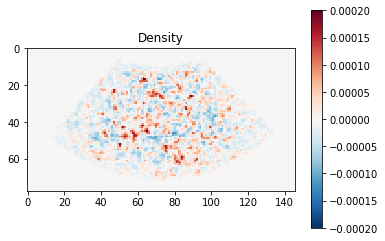

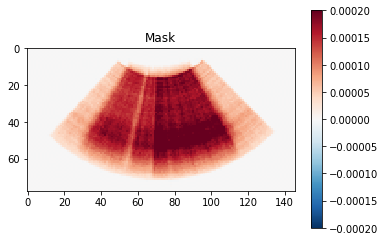

In [32]:
plotter(density_grid,vmax=0.0002,title='Density')
plotter(rand_grid,vmax=0.0002,title='Mask')

### 3. Define weighting
Next, we define a weighting scheme for the data by specifying the $\mathsf{S}^{-1}$ function. Ideally, $$\mathsf{S}^{-1}(\vec x,\vec y) = \left[W\xi+\beta\mathsf{I}\right]^{-1}(\vec x, \vec y)$$ for mask matrix $W$ and data two-point function matrix $\xi$ (with shot-noise specified by $\beta\approx 1$). If the mask contains holes or local lines-of-sight, this cannot be computed analytically. We can either use an approximate weighting $\mathsf{S}^{-1}$ (which does not bias the estimator), or compute the full solution with conjugate gradient descent. 

Here, we'll assume the FKP limit, using $$\mathsf{S}^{-1}(\vec x,\vec y) = \frac{\delta_{\rm D}(\vec x-\vec y)}{n_z(\vec x)P_{\rm FKP}+1} \equiv w_{\rm FKP}(\vec x)\delta_{\rm D}(\vec x-\vec y),$$
where $n_z(\vec x)$ is the (volumetric) redshift distribution, taken from the data. To compute this, we'll first load the PolyBin3D class. This takes the attributes computed above and a few other parameters (such as the choice of pixel window, and our definition of the redshift-axis).

In [33]:
# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, 
                 Pk=None, # fiducial Pk for generating MC simulations (here set to 1 to simplify ideal Fisher matrix)
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )


# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [7.32e+02, 1.49e+01, 2.31e+02] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [78, 146, 82]
# Fundamental frequency: [0.006, 0.003, 0.006] h/Mpc
# Nyquist frequency: [0.242, 0.241, 0.243] h/Mpc
# Pixel window: interlaced-tsc


We then create an interpolator for $n_z(z)$:

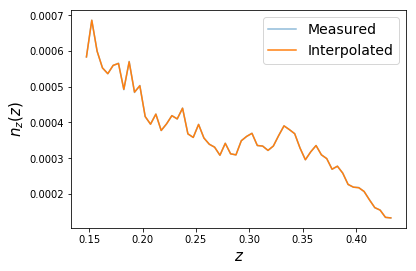

In [34]:
# Histogram the z values, giving dN = n(z)*dz
nz,z = np.histogram(_cat['Z'].compute(),bins=np.arange(ZMIN-0.005,ZMAX+0.0051,0.005),weights=_cat['WEIGHT'].compute(),range=[ZMIN-0.005,ZMAX+0.005])
z_av = 0.5*(z[:-1]+z[1:])
rz = cosmo.comoving_distance(z)

# Convert to volume density i.e. dN = n_z(z)dV
f_sky = eff_area/(4.*np.pi*(180./np.pi)**2.)
volz = 4.*np.pi/3.*(rz[1:]**3.-rz[:-1]**3.)*f_sky
nz_interp = UnivariateSpline(z_av,nz/volz,s=0.00000000001)

# Plot the distribution
plt.plot(z_av, nz/volz, label='Measured',alpha=0.5)
plt.plot(z_av, nz_interp(z_av), label='Interpolated')
plt.xlabel(r'$z$',fontsize=15)
plt.ylabel(r'$n_z(z)$',fontsize=15)
plt.legend(fontsize=14);

Next, we compute a 3D grid of $n_z(\vec x)$, and the $\mathsf{S}^{-1}$ function itself. Note that this must take real- or Fourier-space inputs and outputs (to avoid unnecessary Fourier-transforms). To be clean, we'll also zero any pixels that fall outside the RA/Dec/z-range of the data (since the inverse pixel window can bleed into these regions).

In [35]:
# Create a grid of n(z) for each voxel
ra_grid, dec_grid, z_grid = transform.CartesianToSky(np.asarray([r.ravel() for r in base.r_grids]).T,cosmo)
ra_grid = ra_grid.compute().reshape(base.r_grids[0].shape)
dec_grid = dec_grid.compute().reshape(base.r_grids[0].shape)
z_grid = z_grid.compute().reshape(base.r_grids[0].shape)
nz_grid = nz_interp(z_grid)

# Broadly pixelize the RA / Dec coordinates
Nside = 64
hp_pixels = hp.ang2pix(Nside, cat['RA'].compute(), cat['DEC'].compute(), lonlat=True)
hp_map = np.zeros(hp.nside2npix(64))
hp_map[hp_pixels] = 1

# Define the edges of the mask
zero_grid = hp_map[hp.ang2pix(Nside, ra_grid, dec_grid, lonlat=True)]*(z_grid>=ZMIN)*(z_grid<ZMAX)

# Define FKP weight, cutting out any pixels outside the z-range of interest
P_fkp = 1e4
fkp_weight = 1./(1.+P_fkp*nz_grid)*zero_grid

# Define filtering
def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply an FKP-like filter to the data."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply FKP weight in real-space
    output_real = input_real*fkp_weight
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

Let's test the weighting out (note that the code actually applies the weighting to the pixel-window-deconvolved data, $M^{-1}d$ rather than $d$):

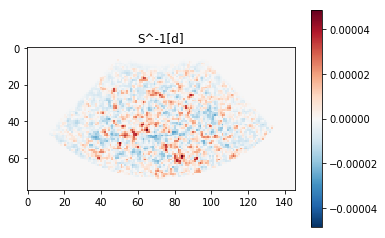

In [36]:
plotter(applySinv_fkp(density_grid),title='S^-1[d]')

### 4. Compute the usual (pseudo)-power spectra
As a first test, we'll compute the conventional window-convolved power spectra with PolyBin3D. 

To do this, we first load the power spectrum class with our choice of weighting and number density distribution. Note that we can optionally choose to include power spectra, $P_\ell(k)$, with odd $\ell$; these can be generated by wide-angle effects and mask convolution. We note that these are somewhat more difficult to compute in the unwindowed-estimator formalism as the Fisher matrix is slower to converge. However, excluding them from the calculation does *not* bias the estimation of $P_{\ell=\rm even}$, except at second-order in the small parameter $1/(kd)$, where $d$ is the distance to the sample.

After loading the class, we run the power spectrum estimator ```pspec.Pk_unwindowed()``` to compute the power spectra. Here, we'll use an idealized normalization scheme that does not correct for leakage between bins, since we want to compute *window-convolved* spectra. We'll also assume the classical normalization:
$$N_2 = \int d\vec x\,n(\vec x)n_z(\vec x)w_{\rm FKP}^2(\vec x),$$
as well as the shot-noise rescaling
$$\beta = \left[\sum_i w^2_{i,\rm gal}+\alpha^2\sum_j w^2_{j,\rm rand}\right]/\sum_i w_{i,\rm gal}$$
for $\alpha = \sum_i w_{i,\rm gal}/\sum_j w_{j,\rm rand}$. This factor $\gtrsim 1$ encodes the additional shot-noise from the random catalog and the completeness weights.

In [37]:
# Define some k-bins and ell_max
k_edges = np.arange(0.0063,0.245,0.02)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, 
                 applySinv = applySinv_fkp, # S^-1 weighting function
                 mask = rand_grid, # pixel-window-deconvolved mask
                 lmax = lmax, # maximum multipole
                 odd_l=False) # whether to include odd multipoles 

# Define FKP normalization on the grid
pk_norm = np.sum(nz_grid*rand_grid*fkp_weight**2)/gridsize.prod()

# Compute the shot-noise rescaling [from completeness weights]
beta = ((np.sum(cat['WEIGHT']**2.)+alpha**2*np.sum(cat_rand['WEIGHT']**2.))/np.sum(cat['WEIGHT'])).compute()

# Compute the ideal normalization matrix (just encoding the bin volumes, and some discreteness effects)
fish_ideal = pk_norm*pspec.compute_fisher_ideal()

# Compute the *window-convolved* spectrum
Pk_fkp = pspec.Pk_unwindowed(density_grid, fish=fish_ideal, subtract_shotnoise=False)


Binning: 11 bins in [0.006, 0.226] h/Mpc
l-max: 4
Mask: spatially varying
Generating spherical harmonics
Computing ideal Fisher matrix


For comparison, we can compute the power spectrum using Nbodykit:

In [38]:
# Add an n_z column for the catalog (using our fiducial cosmology)
cat['nz'] = nz_interp(cat['Z'])
cat_rand['nz'] = nz_interp(cat_rand['Z'])

# Define FKP weights
cat['fkp_weight'] = 1./(P_fkp*cat['nz']+1.)
cat_rand['fkp_weight'] = 1./(P_fkp*cat_rand['nz']+1.)

# Recompute the density-field with the pixel-window-compensation and FKP weights applied, and shifting along the line-of-sight
cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
cat_fkp_nb['data/Position'] += boxcenter
cat_fkp_nb['randoms/Position'] += boxcenter
density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, interlaced=True, 
                               compensated=True,position='Position',
                               fkp_weight='fkp_weight', comp_weight='WEIGHT', resampler='tsc')

# Compute the Nbodykit power spectrum in the same bins
r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])

# Reshape output
Pk_nb = {'p0':r.poles['power_0'].real,'p2':r.poles['power_2'].real,'p4':r.poles['power_4'].real}

Let's compare the two! Below, we plot the power spectrum multipoles $P_{0,2,4}(k)$ in our $k$-bins. We find good agreement in general. Slight differences arise from (a) computing FKP weights on the grid instead of at the catalog level, (b) PolyBin3D accounting for discreteness effects in the Fourier-space grid (giving slightly more accurate estimation of low-$k$ modes with $\ell>0$), (c) defining the normalization on the grid instead of at the catalog level. 

All the above effects will be fully accounted for by the optimal estimators, which take the gridding and discreteness effects into account in both the numerator and normalization.

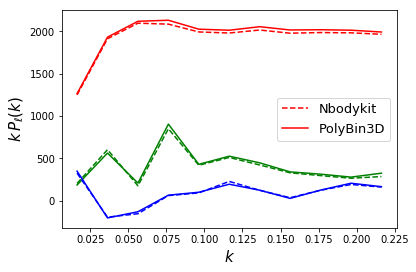

In [39]:
# Compute k 
k_cen = pspec.get_ks()

cs = {0:'r',1:'purple',2:'g',3:'orange',4:'blue'}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2,4]):
    plt.plot(k_cen, k_cen*Pk_nb['p%d'%l],c=cs[l],ls='--',label='Nbodykit')
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l],c=cs[l],ls='-',label='PolyBin3D')
    if li==0: plt.legend(fontsize=13)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5. Compute the "unwindowed" power spectra

Now we compute the main quantity of interest; window-deconvolved galaxy power spectrum measurements. For this, we first compute the Fisher matrix, $\mathcal{F}_{\alpha\beta}$ using Monte Carlo methods. This encodes the coupling between different modes induced by the local line-of-sight as well as mask-induced leakage, $\mathsf{S}^{-1}$ weighting and pixelation artefacts. This matrix is defined by requiring that the estimator returns an unbiased estimate of the power spectrum band-powers, given the mask and $\mathsf{S}^{-1}$ function.

The Fisher matrix can be expensive to compute, should usually be paralellized. Here, we use a small number of realizations for testing (though more is usually useful in practice), computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method, which additionally allows for multi-processing. This additionally computes the Poissonian shot-noise term in the power spectrum estimator. Note that this does not depend on the data, so only has to be computed once!

In [40]:
# Number of Monte Carlo iterations
N_it = 20

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output, computing the mean of the quantities
fish = np.mean([f[0] for f in fish_and_shot],axis=0)
shot_num = np.mean([f[1] for f in fish_and_shot],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish, shot_num = pspec.compute_fisher(N_it, N_cpus=1, verb=True)

Computing iteration 1 of 20
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 20
Computing iteration 3 of 20
Computing iteration 4 of 20
Computing iteration 5 of 20
Computing iteration 6 of 20
Computing iteration 7 of 20
Computing iteration 8 of 20
Computing iteration 9 of 20
Computing iteration 10 of 20
Computing iteration 11 of 20
Computing iteration 12 of 20
Computing iteration 13 of 20
Computing iteration 14 of 20
Computing iteration 15 of 20
Computing iteration 16 of 20
Computing iteration 17 of 20
Computing iteration 18 of 20
Computing iteration 19 of 20
Computing iteration 20 of 20


Let's plot the matrix and compare it to the idealized form given above. These appear quite different; this is due to the mask- (and weighting-)induced leakage between $k$-bins and multipoles. We find significant leakage between adjacent power spectrum bins, and some minor leakage between higher-multipoles (the off-diagonal stripes in the correlation matrix). In contrast, the idealized Fisher matrix is almost diagonal (except for some small discreteness effects).

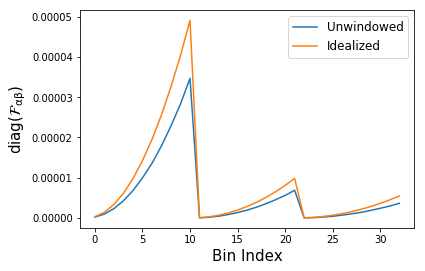

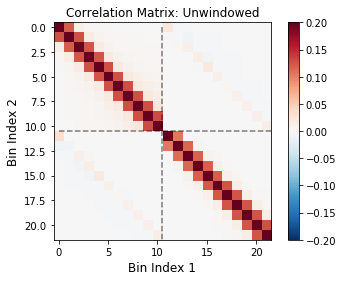

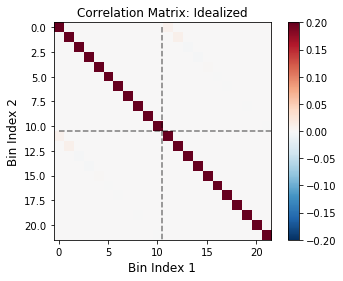

In [41]:
# Plot the diagonal
plt.plot(np.arange(len(fish)),np.diag(fish),label='Unwindowed')
plt.plot(np.diag(fish_ideal),label='Idealized')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\rm{diag}(\mathcal{F}_{\alpha\beta})$',fontsize=15);
plt.legend(fontsize=12);

# Plot the correlation structure
plot_corr(fish,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed')
plot_corr(fish_ideal,v=0.2,subtract_identity=False,title='Correlation Matrix: Idealized')

We now compute the power spectra, using the same routines as before, but feeding in our new Fisher matrix. We'll also consider varying the Fisher matrix to establish the impact of Monte Carlo noise in the Fisher matrix computation.

In [42]:
# Compute unwindowed power spectra
Pk_unwindowed = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Estimate Monte Carlo error by using two estimates of the Fisher matrix
fish1 = np.mean([f[0] for f in fish_and_shot[:N_it//2]],axis=0)
fish2 = np.mean([f[0] for f in fish_and_shot[N_it//2:]],axis=0)
Pk1 = pspec.Pk_unwindowed(density_grid, fish=fish1, shot_num=shot_num, subtract_shotnoise=False)
Pk2 = pspec.Pk_unwindowed(density_grid, fish=fish2, shot_num=shot_num, subtract_shotnoise=False)
Pk_err = {key: np.abs(Pk1[key]-Pk2[key]) for key in Pk_unwindowed}

Computations complete using 2192 forward and 6924 reverse FFTs


Let's plot the power spectra below. We find a couple of important conclusions:
- Unwindowed power spectra are $\sim  10\%$ larger than the windowed equivalents. This reflects a known issue with the normalization of FKP spectra - the $N_2$ factor used in Nbodykit is a slight overestimate (which can be encapsulated by the window function). Here, we define the normalization completely in terms of the random catalog. 
- There is some residual uncertainty from the Monte Carlo computation of the Fisher matrix, particularly in the higher multipoles. This can be reduced by using more Monte Carlo realizations.
- The output spectra from PolyBin3D are (approximately) unwindowed *i.e.* they can be compared directly to theory, without need for window convolution. This assumes that the $k$-range given to PolyBin3D encompasses all relevant modes. For the highest $k$-modes in our estimator, we will miss contributions from modes at slightly higher $k$, thus these should generally be discarded (see e.g. the last monopole bin below). This can easily be ameliorated by measuring a larger range of $k$ than used in practice.

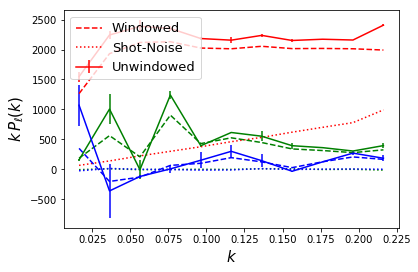

In [43]:
# Compute k 
k_cen = pspec.get_ks()

cs = {0:'r',1:'purple',2:'g',3:'orange',4:'blue'}

# Define shot-noise
Pk_shot = {'p%d'%l:pspec.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk] for l in [0,2,4]}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2,4]):
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*Pk_err['p%d'%l],
                 c=cs[l],ls='-',label='Unwindowed')
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l],c=cs[l],ls='--',label='Windowed')
    plt.plot(k_cen, beta*k_cen*Pk_shot['p%d'%l],c=cs[l],ls=':',label='Shot-Noise')
    if li==0: plt.legend(fontsize=13)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5a. Bonus #1: compute optimally-weighted spectra

Although the above spectra are window-deconvolved they are not quite optimal, due to the simplifying FKP-like $\mathsf{S}^{-1}$ assumed. In the below, we'll compute the spectra using the optimal $\mathsf{S}^{-1}$. Applied to a vector $u$ (which doesn't vanish with the mask), the inverse can be obtained by solving
$$[W\xi + \beta \mathsf{I}]\Phi\left(\mathsf{S}^{-1}u\right) = u$$
for $\mathsf{S}^{-1}u$ via conjugate gradient descent methods (where $\beta$ is the shot-noise rescaling discussed above, and $\Phi$ kills modes for which the window is zero). Below, we implement this, computing the correlation function term in Fourier space, assuming a local line-of-sight.

In [44]:
### First set up the matrix [W xi + beta I](x, y)

# Create a simple galaxy power spectrum, that we'll use for weighting
redshift = np.average(cat['Z'],weights=cat['WEIGHT'])
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
# Note that this does not include shot-noise!
k_arr = np.arange(0.0001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr

# Interpolate the spectra to a grid
Pkl_grid = {0:interp1d(k_arr, P0_arr, bounds_error=False, fill_value=0)(base.modk_grid),
            2:interp1d(k_arr, P2_arr, bounds_error=False, fill_value=0)(base.modk_grid),
            4:interp1d(k_arr, P4_arr, bounds_error=False, fill_value=0)(base.modk_grid)
           }

# Define spherical harmonics
Ylm_fourier = base._compute_real_harmonics(base.k_grids, pspec.lmax, odd_l=False)

# Define zeros of mask
Phi_grid = np.array(zero_grid,dtype='bool')

# Define the mean of the mask
mean_mask = np.average(nz_grid,weights=Phi_grid)

# Function to apply the forward matrix
def apply_matrix(_input_map):
    """Apply the matrix [W xi + beta I](x, y)Phi(y) to a map."""
    
    # Remove pixels outside the mask
    input_map = _input_map*Phi_grid
    
    # Apply the power spectrum in Fourier-space (up to k_max)
    xi_dot_fourier = 0.+0.j
    for l in range(0,pspec.lmax+1,2):
        if l==0:
            leg_map = base.to_fourier(input_map)
        else:
            leg_map = np.sum([Ylm_fourier[l][lm_ind]*base.to_fourier(input_map*pspec.Ylm_real[l][lm_ind]) for lm_ind in range(len(Ylm_fourier[l]))],axis=0)
        xi_dot_fourier += leg_map*Pkl_grid[l]*(base.modk_grid<kmax)
    xi_dot_real = base.to_real(xi_dot_fourier).real
    
    # Apply the mask and Poisson noise
    output_map = nz_grid*xi_dot_real + beta*input_map.real
    
    # Return output, killing pixels outside the range of interest
    return output_map*Phi_grid

# CGD function
def cgd_inverse(input_map, applySinv_approx=applySinv_fkp, max_it=25, rel_tol=1e-3, verb=False):
    """Compute the conjugate gradient descent inverse solution for S^-1."""
    
    # Start timer
    start = time.time()
    
    # define initial guess for inverse and first term in sequence
    if verb: print("Computing initial guess")
    x = applySinv_approx(input_map)
    r = input_map - apply_matrix(x)
    p = applySinv_approx(r)
    C_p = apply_matrix(p)

    pre_r = applySinv_approx(r)
    old_sum = np.sum(r*pre_r)
    init_sum = old_sum.copy()
    alpha = old_sum/np.sum(p*C_p)
    save_sum = old_sum.copy()

    assert max_it < len(input_map.ravel())

    for i in range(max_it):
        if i>0 and verb: print("Starting iteration %d of %d: ratio = %.2e"%(i,max_it,np.sqrt(new_sum/init_sum)))
        
        if i%10==0 and i>0:
            # Check for stalling and stop if stalled
            if np.abs((save_sum-old_sum)/old_sum)<0.05:
                if verb: print("Inversion stalled after step %d; exiting (ratio %.2e/%.2e)"%(i+1,new_sum,init_sum))
                break
        
        # update x
        x = x+alpha*p
        # update r
        r = r-alpha*C_p
        # update S_approx^-1.r
        pre_r = applySinv_approx(r)
        # update sum(r * S_approx^-1.r)
        new_sum = np.sum(r*pre_r)
        # update p
        p = pre_r + (new_sum/old_sum)*p
        # Check for convergence
        if new_sum/init_sum<0:
            print("Bad sum on iteration %d (ratio %.2e/%.2e"%(i,new_sum,init_sum))
            break
        if np.sqrt(new_sum/init_sum)<rel_tol:
            if verb: print("Inversion stopped early after %d iterations (ratio %.2e/%.2e)"%(i+1,new_sum,init_sum))
            break
        
        # update sum
        old_sum = new_sum
        # update C.p
        C_p = apply_matrix(p)
        # compute alpha
        alpha = old_sum/np.sum(p*C_p)
    if i==max_it-1:
        if verb: print("CGD did not stop early: is this converged? (ratio %.2e/%.2e)"%(new_sum,init_sum))
    if verb:
        print("\nInversion took %.1f seconds"%(time.time()-start))
    return x

# Define inverse Pk, *including* shot-noise piece
invPk0_grid = np.zeros_like(z_grid)
invPk0_grid[Pkl_grid[0]!=0] = 1./(Pkl_grid[0][Pkl_grid[0]!=0]+1./mean_mask)

# Define filtering
def applySinv_simplified(input_data, input_type='real', output_type='real'):
    """Apply a simplified filter to the data, assuming that both input and output maps are in real-space."""
   
    # Apply zero mask in real-space and divide by n(z)
    input_real = input_data*Phi_grid
    input_real[Phi_grid] /= nz_grid[Phi_grid]
    
    # Transform to Fourier space and apply inverse monopole (including shot-noise)
    output_fourier = base.to_fourier(input_real)*invPk0_grid
    
    # Return output in real-space
    return Phi_grid*base.to_real(output_fourier).real

Let's test this by applying the CGD to a pixel-window-deconvolved map. We find that the CGD has found the correct solution to moderate accuracy ($\sim 1\%$, as desired), though this usually requires quite a few number of Fourier transforms. The efficiency of the CGD inversion depends primarily on the choice of preconditioner, i.e. the approximate $\mathsf{S}^{-1}$ assumed to begin with. Above, we assume a simplified form, obtained by dividing the map by $n_z(\vec x)$, then filtering by the inverse power spectrum monopole in Fourier-space.

Computing initial guess
Starting iteration 1 of 25: ratio = 5.25e-01
Starting iteration 2 of 25: ratio = 2.04e-01
Starting iteration 3 of 25: ratio = 1.34e-01
Starting iteration 4 of 25: ratio = 6.02e-02
Starting iteration 5 of 25: ratio = 3.43e-02
Starting iteration 6 of 25: ratio = 1.76e-02
Inversion stopped early after 7 iterations (ratio 3.67e-07/4.79e-03)

Inversion took 8.0 seconds


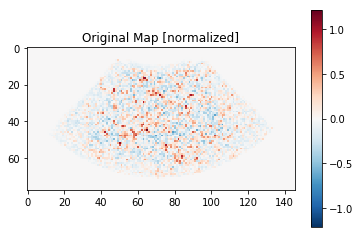

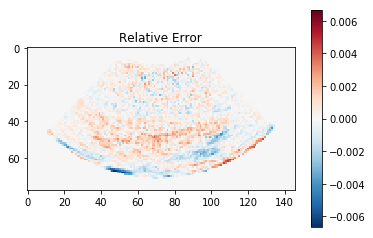

In [45]:
# Define input map
input_map = base.to_real(base.to_fourier(density_grid)/base.pixel_window_grid).real

# Apply CGD inverse
Sinv_map = cgd_inverse(input_map, applySinv_approx=applySinv_simplified, max_it=25, verb=True, rel_tol=1e-2)

# Plot, comparing [W xi + beta I].Phi.S^-1.x to the original map, x
plotter(input_map*Phi_grid/np.average(pspec.mask,weights=Phi_grid),title='Original Map [normalized]')
plotter((input_map*Phi_grid-apply_matrix(Sinv_map))/np.average(pspec.mask,weights=Phi_grid),title='Relative Error')

Now we can wrap the inverse in an $\mathsf{S}^{-1}$ function and proceed to compute the power spectrum and Fisher matrix! This will take quite a bit longer than before since each application of $\mathsf{S}^{-1}$ is quite expensive (and we have to compute it $N_{\rm bins}+1$ times), so we'll just use a few Monte Carlo realizations. Note that we can use a relatively poor error-tolerance on the CGD; as long as we use the same *approximate* form for $\mathsf{S}^{-1}$ everywhere, the estimator will be unbiased.

In [46]:
# Define filtering
def applySinv_optimal(input_data, input_type='real', output_type='real'):
    """Apply an optimal filter to the data, using conjugate gradient descent."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data).real
    else:
        input_real = input_data.copy().real
    
    # Apply FKP weight in real-space, using reduced error tolerance for testing
    output_real = cgd_inverse(input_real, max_it=25, rel_tol=1e-2, verb=False)
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

# Load the power spectrum class
pspec_opt = pb.PSpec(base, k_edges, 
                 applySinv = applySinv_optimal, # S^-1 weighting function
                 mask = rand_grid, # pixel-window-deconvolved mask
                 lmax = lmax, # maximum multipole
                 odd_l=False) # whether to include odd multipoles  


Binning: 11 bins in [0.006, 0.226] h/Mpc
l-max: 4
Mask: spatially varying
Generating spherical harmonics


In [48]:
# Number of Monte Carlo iterations
N_it = 10

# Zero counters
base.n_FFTs_forward = 0
base.n_FFTs_reverse = 0

# Iterate over realizations
fish_and_shot_opt = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot_opt.append(pspec_opt.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output, computing the mean of the quantities
fish_opt = np.mean([f[0] for f in fish_and_shot_opt],axis=0)
shot_num_opt = np.mean([f[1] for f in fish_and_shot_opt],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish_opt, shot_num_opt = pspec_opt.compute_fisher(N_it, N_cpus=1, verb=True)

Computing iteration 1 of 10
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 10
Computing iteration 3 of 10
Computing iteration 4 of 10
Computing iteration 5 of 10
Computing iteration 6 of 10
Computing iteration 7 of 10
Computing iteration 8 of 10
Computing iteration 9 of 10
Computing iteration 10 of 10


In [49]:
# Compute unwindowed power spectra
Pk_unwindowed_opt = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt, shot_num=shot_num_opt, subtract_shotnoise=False)

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Estimate Monte Carlo error by using two estimates of the Fisher matrix
fish_opt1 = np.mean([f[0] for f in fish_and_shot_opt[:N_it//2]],axis=0)
fish_opt2 = np.mean([f[0] for f in fish_and_shot_opt[N_it//2:]],axis=0)
Pk_opt1 = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt1, shot_num=shot_num_opt, subtract_shotnoise=False)
Pk_opt2 = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt2, shot_num=shot_num_opt, subtract_shotnoise=False)
Pk_opt_err = {key: np.abs(Pk_opt1[key]-Pk_opt2[key]) for key in Pk_unwindowed_opt}

Computations complete using 184306 forward and 15676 reverse FFTs


Let's make some plots. First, we'll examine the normalizing Fisher matrices. Notably, the optimal estimators have a very different Fisher matrix to the FKP-weighted estimators; this is because they encode the correlations induced by the power spectrum (unlike the FKP-weighted estimators, which assume $P(\vec k)\approx P_{\rm FKP}$). If our CGD weighting is perfect, the inverse of the Fisher matrix will match the covariance of the dataset. 

We also find significant differences in the correlation structures. In particular, we find significant correlations between the $\ell=0$ and $\ell=2$ modes; this traces the physical correlations induced by redshift-space distortions. In both cases, we find significant correlations between neighboring bins (but not in the idealized estimator); this acts to correct the mask-induced leakage.

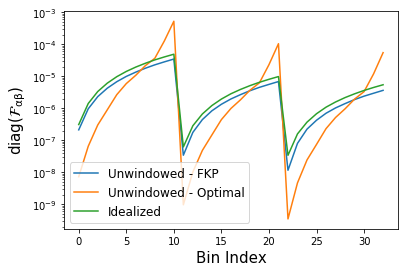

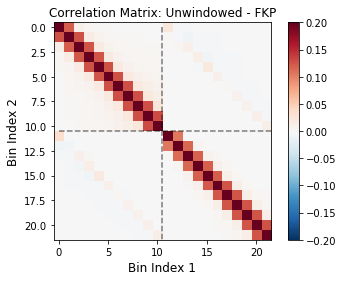

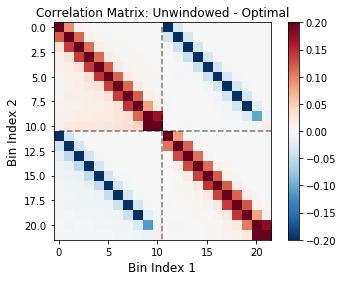

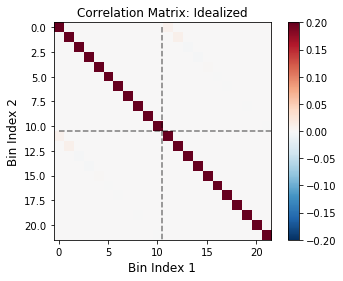

In [50]:
# Plot the diagonal
plt.plot(np.arange(len(fish)),np.diag(fish),label='Unwindowed - FKP')
plt.plot(np.arange(len(fish)),np.diag(fish_opt),label='Unwindowed - Optimal')
plt.plot(np.diag(fish_ideal),label='Idealized')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\rm{diag}(\mathcal{F}_{\alpha\beta})$',fontsize=15);
plt.legend(fontsize=12);
plt.yscale('log');

# Plot the correlation structure
plot_corr(fish,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed - FKP')
plot_corr(fish_opt,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed - Optimal')
plot_corr(fish_ideal,v=0.2,subtract_identity=False,title='Correlation Matrix: Idealized')

Next, we plot the power spectra themselves. These look very similar between the two sets of estimators. In general, the results should be consistent (the estimators are unbiased for all $\mathsf{S}^{-1}$ weightings), though we caution that the effects of leakage from unmeasured bins will differ. The optimal weightings may offer slightly improved signal-to-noise; this is difficult to estimate without a suite of simulations. Finally, we note that (only with optimal weights), we implicitly compute the windowed Gaussian covariance matrix from the input power spectra, as $\mathcal{F}^{-1}$.

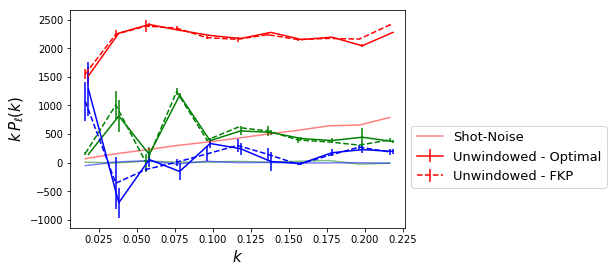

In [51]:
# Compute k 
k_cen = pspec_opt.get_ks()
dk = k_cen[1]-k_cen[0]

cs = {0:'r',2:'g',4:'blue'}
cs2 = {0:'darkred',2:'darkgreen',4:'darkblue'}

# Define shot-noise
Pk_shot = {'p%d'%l:pspec_opt.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk] for l in [0,2,4]}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2,4]):
    plt.errorbar(k_cen+dk/10, k_cen*Pk_unwindowed_opt['p%d'%l],yerr=k_cen*Pk_opt_err['p%d'%l],
                 c=cs[l],ls='-',label='Unwindowed - Optimal')
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*Pk_err['p%d'%l],
                 c=cs[l],ls='--',label='Unwindowed - FKP')
    plt.plot(k_cen, k_cen*Pk_shot['p%d'%l],c=cs[l],ls='-',label='Shot-Noise',alpha=0.5)
    if li==0: plt.legend(fontsize=13,bbox_to_anchor=(1.,0.5))
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5b. Bonus #2: compute rectangular binning matrices

A potential limitation of the unwindowed estimators is that, in order to compare theory and data, one should strictly integrate the theoretical spectra, $P_\ell^{\rm th}(k)$ across each bin. If the bins are sufficiently narrow, this can be avoided, *i.e.* we can assume that the power spectra output by PolyBin3D match the power spectrum evaluated at the center of each bin. For wide bins, one should perform the bin integral, however this is non-trivial since the weighting depends on the mask. 

Below, we discuss how to compute the bin-integration using the ``compute_theory_matrix`` routine. Essentially, one first computes the expectation of the bin numerator
$$\langle{\hat{q}_\alpha\rangle} = \sum_{\gamma}\mathcal{G}_{\alpha\gamma}p_\gamma,$$
where $p_\gamma$ are the band-powers in some *finely-binned* scheme. Then the theoretical expectation of the PolyBin3D outputs, $\hat{p}_\alpha$ are related to the finely binned truth by
$$\langle{\hat{p}_\alpha\rangle} = \sum_\gamma \left[\mathcal{F}^{-1}\mathcal{G}\right]_{\alpha\gamma}p_\gamma.$$
(This is analogous to the bin-convolution matrices in the NaMaster formalism.) We here compute the coupling matrix $\mathcal{G}_{\alpha\gamma}$ using Gaussian random field simulations, as for the Fisher matrix $\mathcal{F}$. Usefully, the total number of FFTs scales as the number of *broad* $k$-bins, not the number of *narrow* $k$-bins. 

For this test, we'll use a finer $k$-binning, with roughly four times the number of bins, and assume the FKP weighting scheme. We'll require an estimate for the *transpose* of the $\mathsf{S}^{-1}$ operator; for FKP weights the function is symmetric.

In [52]:
# First define k-binning
k_edges_th = np.arange(0.0063,0.241,0.005)

# Iterate over realizations
theory_matrices = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    theory_matrix = pspec.compute_theory_matrix(s,
                                                k_edges_th, # theoretical k binning 
                                                applySinv_transpose=applySinv_fkp, # (S^-1)^T operator
                                                verb=(s==0))
    theory_matrices.append(theory_matrix)
    
theory_matrix = np.mean(theory_matrices, axis=0)

Computing iteration 1 of 10
Generating GRF
Computing W^T.S^-T.Q[S^-1.W.a] maps
Computing Q[A^-1.a] maps
Assembling binning matrix

Computing iteration 2 of 10
Computing iteration 3 of 10
Computing iteration 4 of 10
Computing iteration 5 of 10
Computing iteration 6 of 10
Computing iteration 7 of 10
Computing iteration 8 of 10
Computing iteration 9 of 10
Computing iteration 10 of 10


We can now compute the full binning matrix $\mathcal{F}^{-1}\mathcal{G}$. We'll compute this assuming both the unwindowed Fisher matrix $\mathcal{F}$ and the ideal limit. Though the results are a little noisy (though this could be reduced by using more Monte Carlo iterations), it is clear that the finely binned estimators have somewhat different structure.

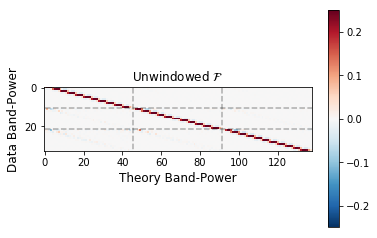

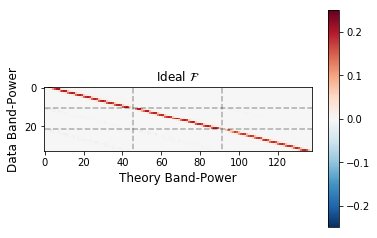

In [53]:
k_cen_th = 0.5*(k_edges_th[1:]+k_edges_th[:-1])

# Apply the F^-1 matrices
correction_matrix = np.matmul(np.linalg.inv(fish),theory_matrix)
correction_matrix_ideal = np.matmul(np.linalg.inv(fish_ideal),theory_matrix)

def plot_matrix(matrix, vmax=1, title=''):
    plt.figure()
    plt.imshow(matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();
    plt.title(title)
    for i in range(1,3):
        plt.hlines(i*pspec.Nk-0.5,0,len(k_cen_th)*3,linestyles='--',alpha=0.3)
        plt.vlines(len(k_cen_th)*i-0.5,0,pspec.Nk*3,linestyles='--',alpha=0.3)
    plt.xlim(-0.5,len(k_cen_th)*3-0.5)
    plt.ylim(pspec.Nk*3-0.5,-0.5);
    plt.xlabel(r'Theory Band-Power',fontsize=12);
    plt.ylabel(r'Data Band-Power',fontsize=12);

plot_matrix(correction_matrix, 0.25, title='Unwindowed $\mathcal{F}$')
plot_matrix(correction_matrix_ideal, 0.25, title='Ideal $\mathcal{F}$')

It's useful to zoom in a little and focus on the monopole. Whilst the matrices are still a little noisy it's clear that there's a lot of leakage between even far-separated bins if we assume the ideal normalization (which does not *de-window* the spectra), but significantly less with the full unwindowed Fisher matrix. There, the majority all of the contributions come from modes within the band-power (the diagonal stripe), as expected.

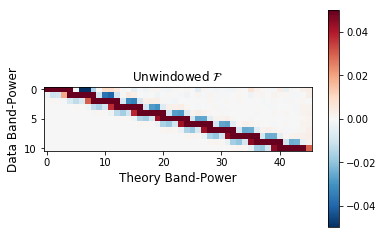

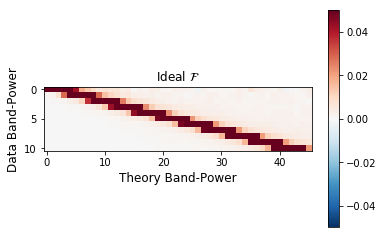

In [54]:
def plot_matrix_zoom(matrix, vmax=1, title=''):
    plt.figure()
    plt.imshow(matrix[:pspec.Nk,:len(k_cen_th)],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();
    plt.title(title)
    plt.xlim(-0.5,len(k_cen_th)-0.5)
    plt.ylim(pspec.Nk-0.5,-0.5);
    plt.xlabel(r'Theory Band-Power',fontsize=12);
    plt.ylabel(r'Data Band-Power',fontsize=12);

plot_matrix_zoom(correction_matrix, 0.05, title='Unwindowed $\mathcal{F}$')
plot_matrix_zoom(correction_matrix_ideal, 0.05, title='Ideal $\mathcal{F}$')

Finally, we can compare the theory predictions using the above correction matrix. The results are very similar (except for the final bin, which we'd usually discard)! This indicates that the effect of varying weights within each bin are small and can usually be ignored, unless the bin width is very large.

Text(0,0.5,'$k\\,P_\\ell(k)$')

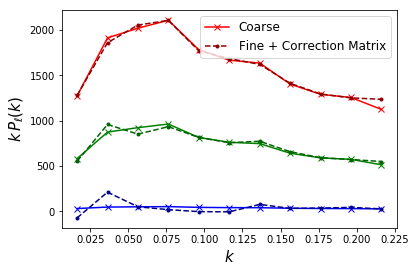

In [55]:
# Input finely binned theory
p_th = np.concatenate([interp1d(k_arr,P0_arr)(k_cen_th),
                       interp1d(k_arr,P2_arr)(k_cen_th),
                       interp1d(k_arr,P4_arr)(k_cen_th)])
# Theory evaluated at bin-centers
p_raw = np.concatenate([interp1d(k_arr,P0_arr)(k_cen),
                        interp1d(k_arr,P2_arr)(k_cen),
                        interp1d(k_arr,P4_arr)(k_cen)])
# Convolved finely-binned theory
p_conv = np.matmul(correction_matrix,p_th)

cs = {0:'r',2:'g',4:'blue'}
cs2 = {0:'darkred',2:'darkgreen',4:'darkblue'}
for l in [0,2,4]:
    plt.plot(k_cen,k_cen*p_raw[l//2*pspec.Nk:(l//2+1)*pspec.Nk],ls='-',marker='x',c=cs[l], label='Coarse')
    plt.plot(k_cen,k_cen*p_conv[l//2*pspec.Nk:(l//2+1)*pspec.Nk],ls='--',marker='.',c=cs2[l], label='Fine + Correction Matrix')
    if l==0: plt.legend(fontsize=12)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

This completes the tutorial! In the remaining tutorials, we'll discuss how to compute bispectra with PolyBin3D!